In [2]:
import time
import os
import sys
import pprint
import numpy as np
import torch
import torchvision.transforms as transforms
import glob
import shutil
import pickle
import argparse
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pandas as pd
import PIL
import PIL.Image
sys.path.append(".")
sys.path.append("..")
from pathlib import Path
from utils.common import tensor2im
from utils.domain_adaptation_utils import run_domain_adaptation
from PIL import Image
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from twodlda import *
from LDA2D import * 
from PIL import Image, ImageOps
from torchvision.utils import save_image
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2

In [3]:
def get_key_ck(fp):
    filename = os.path.splitext(os.path.basename(fp))[0]
    int_part = filename.split()[0]
    int_part = int_part.split('_')[-1]
    return int(int_part) 

def run_alignment(image_path, output_size):
    import dlib
    from scripts.align_faces_parallel import align_face
    predictor = (dlib.shape_predictor(
        "./predictor/shape_predictor_68_face_landmarks.dat"))
    aligned_image = align_face(image_path, predictor,output_size)
    print(f"Finished running alignment on image: {image_path}")
    return aligned_image


def load_subject(s_id):
    subject_dir_set = []
    subject_lbldir_set = []
    dirs_img = glob.glob(f'/data2/artgan/hyperstyle-old/results/new/{s_id}/*')
    for d in dirs_img:
        subject_dir_set.append(os.path.dirname(d))

    X = []

    for d in sorted(dirs_img): 
        l = sorted(glob.glob(d+'/*/*.jpg'),key=get_key_ck)
        X.append(l)

    return X

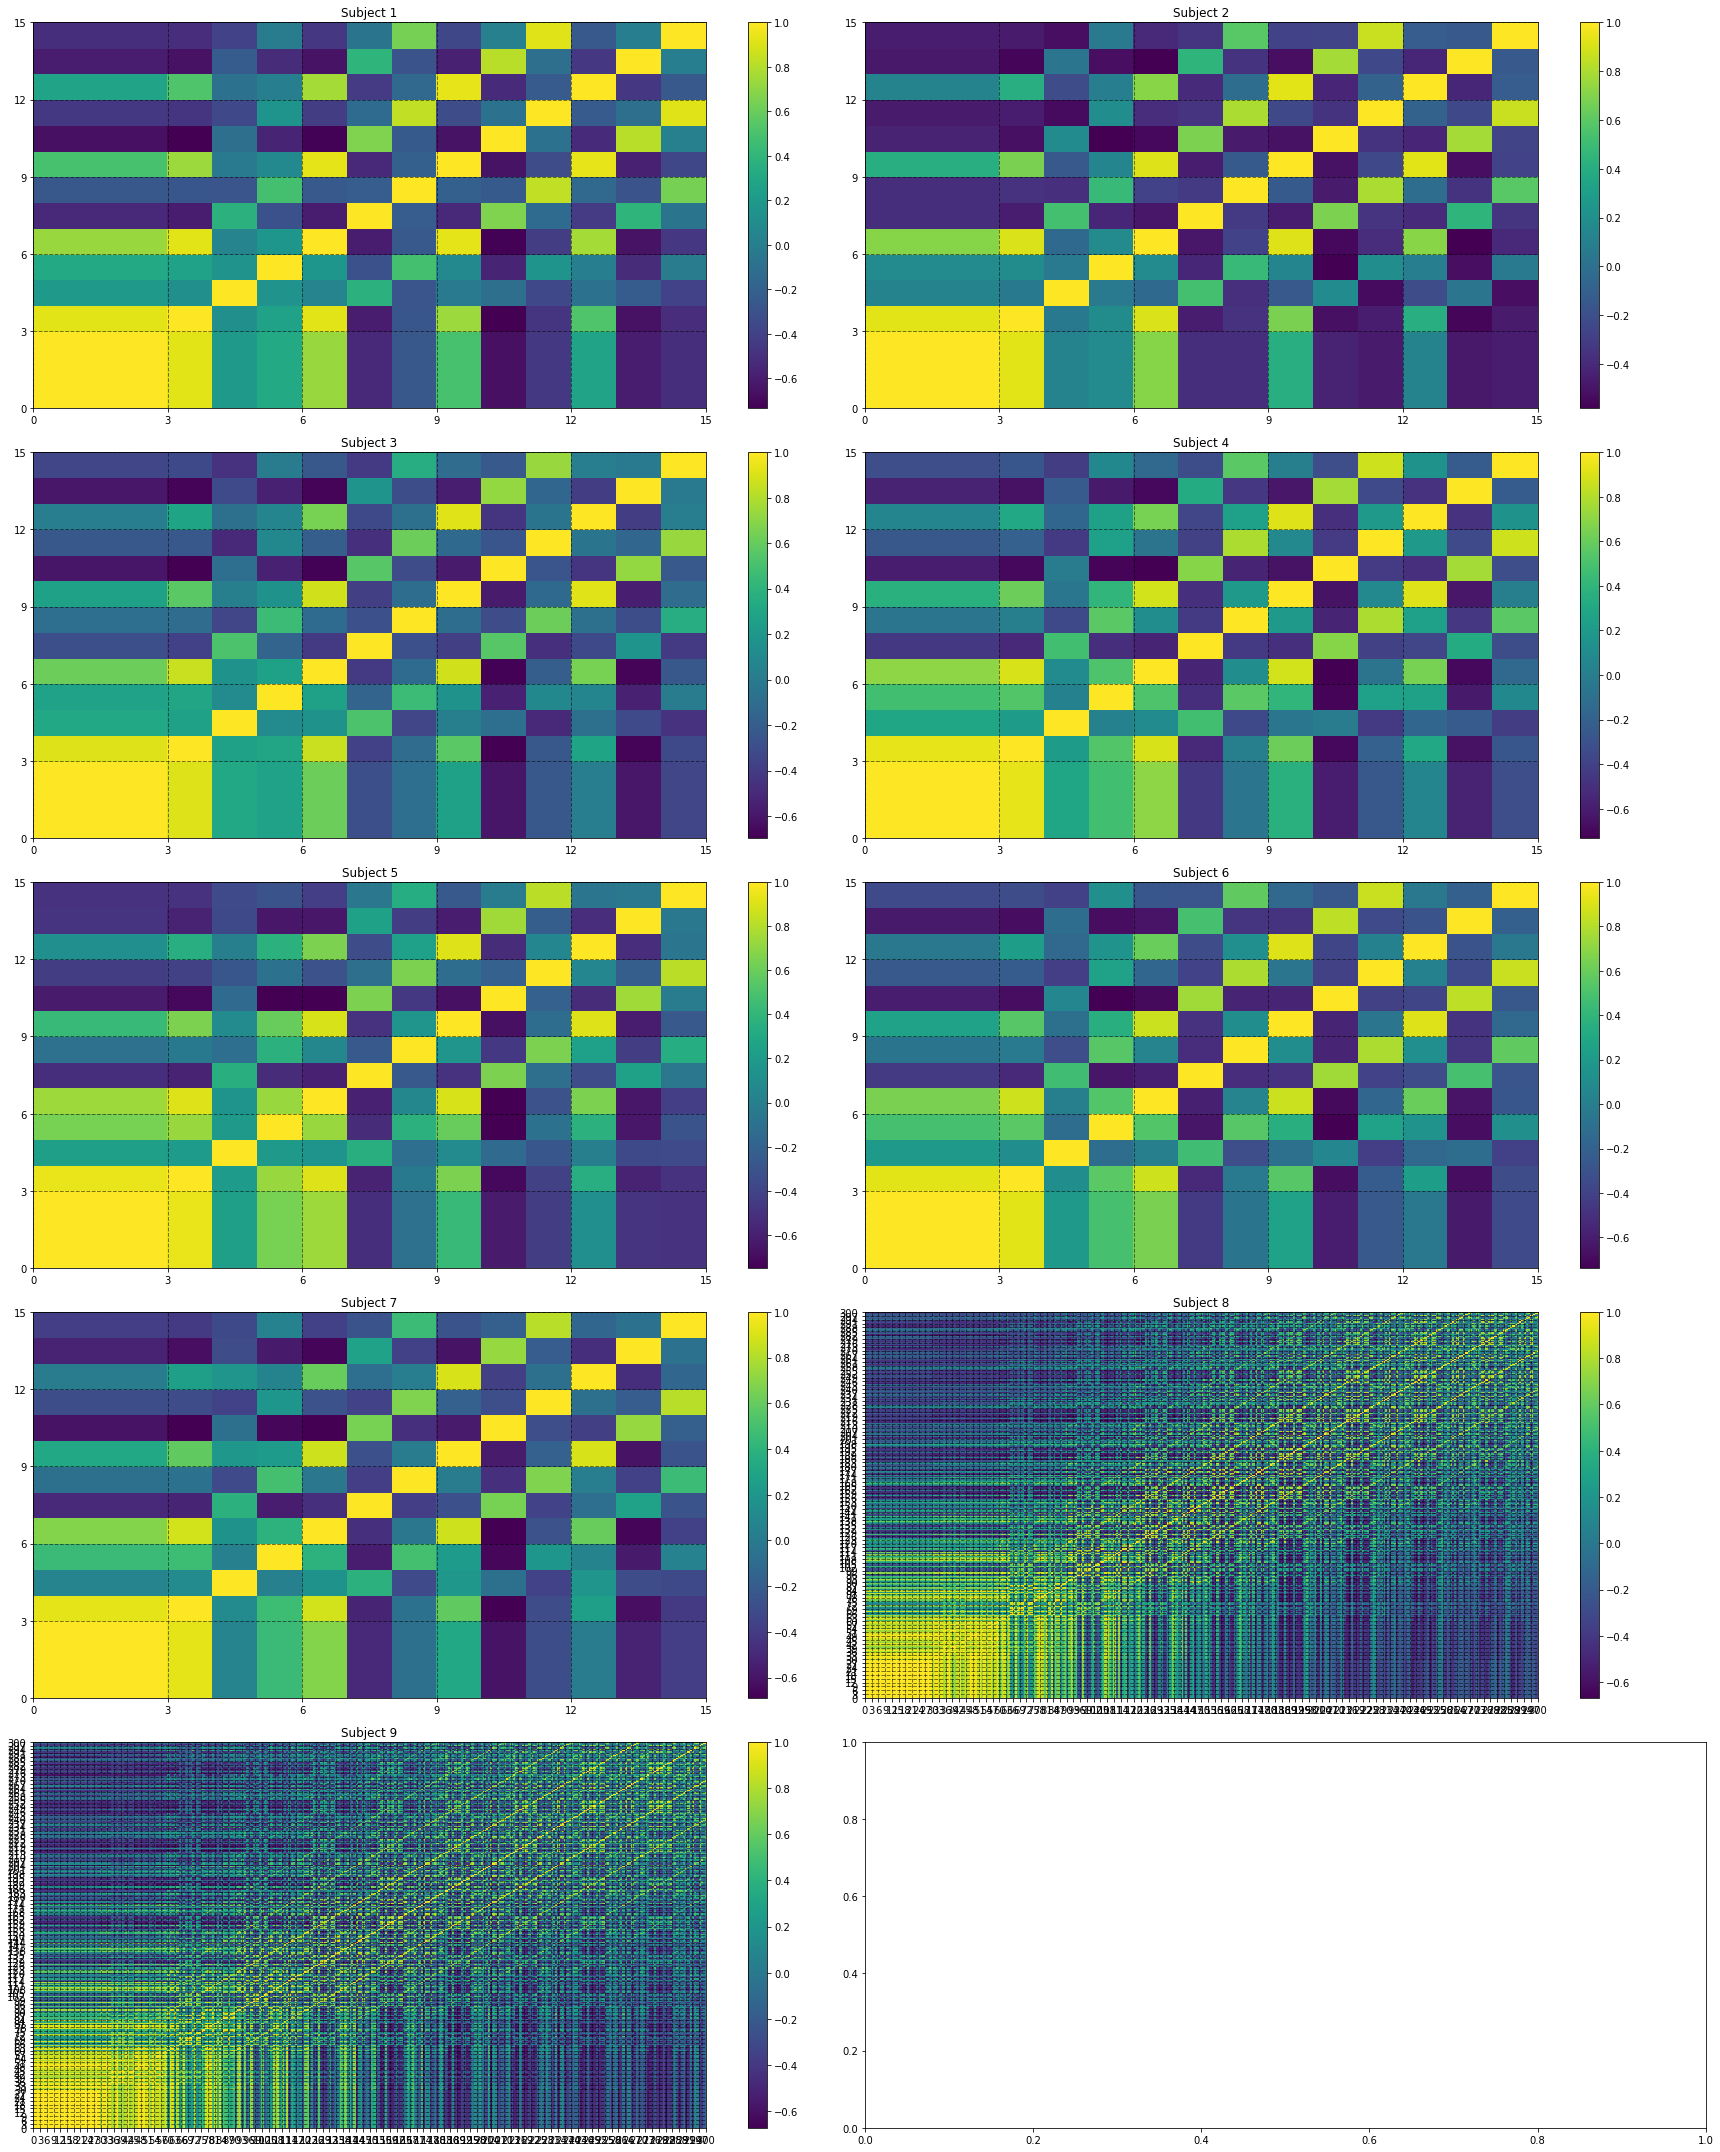

In [4]:
subjects = ['S105', 'S042','S125','S077','S094','S034','S124','S132','S088']
fig, axs = plt.subplots(5, 2, figsize=(24, 30))

# Loop through subjects and populate subplots
for i, s in enumerate(subjects):
    X = load_subject(s)[0]

    tr = transforms.Compose([transforms.Resize((256, 256)),
                             transforms.Grayscale(),transforms.ToTensor()])
    train_imgs = []
    for j, frame in enumerate(X):
        input_image = PIL.Image.open(frame).convert('RGB')
        transformed_image = tr(input_image)
        np_img = ((np.asarray(transformed_image)))[0]
        train_imgs.append(np_img)

    train_imgs = np.array(train_imgs)
    imgs_c = (train_imgs - np.mean(train_imgs,0)).reshape(train_imgs.shape[0],-1)

    # Calculate subplot position
    row = i // 2
    col = i % 2

    # Plot on the current subplot
    pc = axs[row, col].pcolor(np.corrcoef(imgs_c))
    axs[row, col].set_title(f'Subject {i + 1}')
    axs[row, col].grid(True, linewidth=1, color='black', linestyle='--', alpha=0.5)
    axs[row, col].set_xticks(np.arange(0, imgs_c.shape[0] + 1, 3))
    axs[row, col].set_yticks(np.arange(0, imgs_c.shape[0] + 1, 3))
    fig.colorbar(pc, ax=axs[row, col])

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

/data2/artgan/hyperstyle-old/results/new/S105/008/imagen1_0/0_1_0.jpg
/data2/artgan/hyperstyle-old/results/new/S105/008/imagen1_0/0_1_1.jpg
/data2/artgan/hyperstyle-old/results/new/S105/008/imagen1_0/0_1_2.jpg
/data2/artgan/hyperstyle-old/results/new/S105/008/imagen1_0/0_1_3.jpg
/data2/artgan/hyperstyle-old/results/new/S105/008/imagen1_0/0_1_4.jpg
/data2/artgan/hyperstyle-old/results/new/S105/008/imagen1_1/1_1_0.jpg
/data2/artgan/hyperstyle-old/results/new/S105/008/imagen1_1/1_1_1.jpg
/data2/artgan/hyperstyle-old/results/new/S105/008/imagen1_1/1_1_2.jpg
/data2/artgan/hyperstyle-old/results/new/S105/008/imagen1_1/1_1_3.jpg
/data2/artgan/hyperstyle-old/results/new/S105/008/imagen1_1/1_1_4.jpg
/data2/artgan/hyperstyle-old/results/new/S105/008/imagen1_2/2_1_0.jpg
/data2/artgan/hyperstyle-old/results/new/S105/008/imagen1_2/2_1_1.jpg
/data2/artgan/hyperstyle-old/results/new/S105/008/imagen1_2/2_1_2.jpg
/data2/artgan/hyperstyle-old/results/new/S105/008/imagen1_2/2_1_3.jpg
/data2/artgan/hypers

/data2/artgan/hyperstyle-old/results/new/S125/005/imagen1_0/0_1_0.jpg
/data2/artgan/hyperstyle-old/results/new/S125/005/imagen1_0/0_1_1.jpg
/data2/artgan/hyperstyle-old/results/new/S125/005/imagen1_0/0_1_2.jpg
/data2/artgan/hyperstyle-old/results/new/S125/005/imagen1_0/0_1_3.jpg
/data2/artgan/hyperstyle-old/results/new/S125/005/imagen1_0/0_1_4.jpg
/data2/artgan/hyperstyle-old/results/new/S125/005/imagen1_1/1_1_0.jpg
/data2/artgan/hyperstyle-old/results/new/S125/005/imagen1_1/1_1_1.jpg
/data2/artgan/hyperstyle-old/results/new/S125/005/imagen1_1/1_1_2.jpg
/data2/artgan/hyperstyle-old/results/new/S125/005/imagen1_1/1_1_3.jpg
/data2/artgan/hyperstyle-old/results/new/S125/005/imagen1_1/1_1_4.jpg
/data2/artgan/hyperstyle-old/results/new/S125/005/imagen1_2/2_1_0.jpg
/data2/artgan/hyperstyle-old/results/new/S125/005/imagen1_2/2_1_1.jpg
/data2/artgan/hyperstyle-old/results/new/S125/005/imagen1_2/2_1_2.jpg
/data2/artgan/hyperstyle-old/results/new/S125/005/imagen1_2/2_1_3.jpg
/data2/artgan/hypers

/data2/artgan/hyperstyle-old/results/new/S094/001/imagen1_0/0_1_0.jpg
/data2/artgan/hyperstyle-old/results/new/S094/001/imagen1_0/0_1_1.jpg
/data2/artgan/hyperstyle-old/results/new/S094/001/imagen1_0/0_1_2.jpg
/data2/artgan/hyperstyle-old/results/new/S094/001/imagen1_0/0_1_3.jpg
/data2/artgan/hyperstyle-old/results/new/S094/001/imagen1_0/0_1_4.jpg
/data2/artgan/hyperstyle-old/results/new/S094/001/imagen1_1/1_1_0.jpg
/data2/artgan/hyperstyle-old/results/new/S094/001/imagen1_1/1_1_1.jpg
/data2/artgan/hyperstyle-old/results/new/S094/001/imagen1_1/1_1_2.jpg
/data2/artgan/hyperstyle-old/results/new/S094/001/imagen1_1/1_1_3.jpg
/data2/artgan/hyperstyle-old/results/new/S094/001/imagen1_1/1_1_4.jpg
/data2/artgan/hyperstyle-old/results/new/S094/001/imagen1_2/2_1_0.jpg
/data2/artgan/hyperstyle-old/results/new/S094/001/imagen1_2/2_1_1.jpg
/data2/artgan/hyperstyle-old/results/new/S094/001/imagen1_2/2_1_2.jpg
/data2/artgan/hyperstyle-old/results/new/S094/001/imagen1_2/2_1_3.jpg
/data2/artgan/hypers

/data2/artgan/hyperstyle-old/results/new/S124/001/imagen1_0/0_1_0.jpg
/data2/artgan/hyperstyle-old/results/new/S124/001/imagen1_0/0_1_1.jpg
/data2/artgan/hyperstyle-old/results/new/S124/001/imagen1_0/0_1_2.jpg
/data2/artgan/hyperstyle-old/results/new/S124/001/imagen1_0/0_1_3.jpg
/data2/artgan/hyperstyle-old/results/new/S124/001/imagen1_0/0_1_4.jpg
/data2/artgan/hyperstyle-old/results/new/S124/001/imagen1_1/1_1_0.jpg
/data2/artgan/hyperstyle-old/results/new/S124/001/imagen1_1/1_1_1.jpg
/data2/artgan/hyperstyle-old/results/new/S124/001/imagen1_1/1_1_2.jpg
/data2/artgan/hyperstyle-old/results/new/S124/001/imagen1_1/1_1_3.jpg
/data2/artgan/hyperstyle-old/results/new/S124/001/imagen1_1/1_1_4.jpg
/data2/artgan/hyperstyle-old/results/new/S124/001/imagen1_2/2_1_0.jpg
/data2/artgan/hyperstyle-old/results/new/S124/001/imagen1_2/2_1_1.jpg
/data2/artgan/hyperstyle-old/results/new/S124/001/imagen1_2/2_1_2.jpg
/data2/artgan/hyperstyle-old/results/new/S124/001/imagen1_2/2_1_3.jpg
/data2/artgan/hypers

/data2/artgan/hyperstyle-old/results/new/S132/005/imagen5_9/9_5_9.jpg
/data2/artgan/hyperstyle-old/results/new/S132/005/imagen6_0/0_6_0.jpg
/data2/artgan/hyperstyle-old/results/new/S132/005/imagen6_0/0_6_1.jpg
/data2/artgan/hyperstyle-old/results/new/S132/005/imagen6_0/0_6_2.jpg
/data2/artgan/hyperstyle-old/results/new/S132/005/imagen6_0/0_6_3.jpg
/data2/artgan/hyperstyle-old/results/new/S132/005/imagen6_0/0_6_4.jpg
/data2/artgan/hyperstyle-old/results/new/S132/005/imagen6_0/0_6_5.jpg
/data2/artgan/hyperstyle-old/results/new/S132/005/imagen6_0/0_6_6.jpg
/data2/artgan/hyperstyle-old/results/new/S132/005/imagen6_0/0_6_7.jpg
/data2/artgan/hyperstyle-old/results/new/S132/005/imagen6_0/0_6_8.jpg
/data2/artgan/hyperstyle-old/results/new/S132/005/imagen6_0/0_6_9.jpg
/data2/artgan/hyperstyle-old/results/new/S132/005/imagen6_1/1_6_0.jpg
/data2/artgan/hyperstyle-old/results/new/S132/005/imagen6_1/1_6_1.jpg
/data2/artgan/hyperstyle-old/results/new/S132/005/imagen6_1/1_6_2.jpg
/data2/artgan/hypers

/data2/artgan/hyperstyle-old/results/new/S088/001/imagen6_3/3_6_9.jpg
/data2/artgan/hyperstyle-old/results/new/S088/001/imagen6_4/4_6_0.jpg
/data2/artgan/hyperstyle-old/results/new/S088/001/imagen6_4/4_6_1.jpg
/data2/artgan/hyperstyle-old/results/new/S088/001/imagen6_4/4_6_2.jpg
/data2/artgan/hyperstyle-old/results/new/S088/001/imagen6_4/4_6_3.jpg
/data2/artgan/hyperstyle-old/results/new/S088/001/imagen6_4/4_6_4.jpg
/data2/artgan/hyperstyle-old/results/new/S088/001/imagen6_4/4_6_5.jpg
/data2/artgan/hyperstyle-old/results/new/S088/001/imagen6_4/4_6_6.jpg
/data2/artgan/hyperstyle-old/results/new/S088/001/imagen6_4/4_6_7.jpg
/data2/artgan/hyperstyle-old/results/new/S088/001/imagen6_4/4_6_8.jpg
/data2/artgan/hyperstyle-old/results/new/S088/001/imagen6_4/4_6_9.jpg
/data2/artgan/hyperstyle-old/results/new/S088/001/imagen6_5/5_6_0.jpg
/data2/artgan/hyperstyle-old/results/new/S088/001/imagen6_5/5_6_1.jpg
/data2/artgan/hyperstyle-old/results/new/S088/001/imagen6_5/5_6_2.jpg
/data2/artgan/hypers

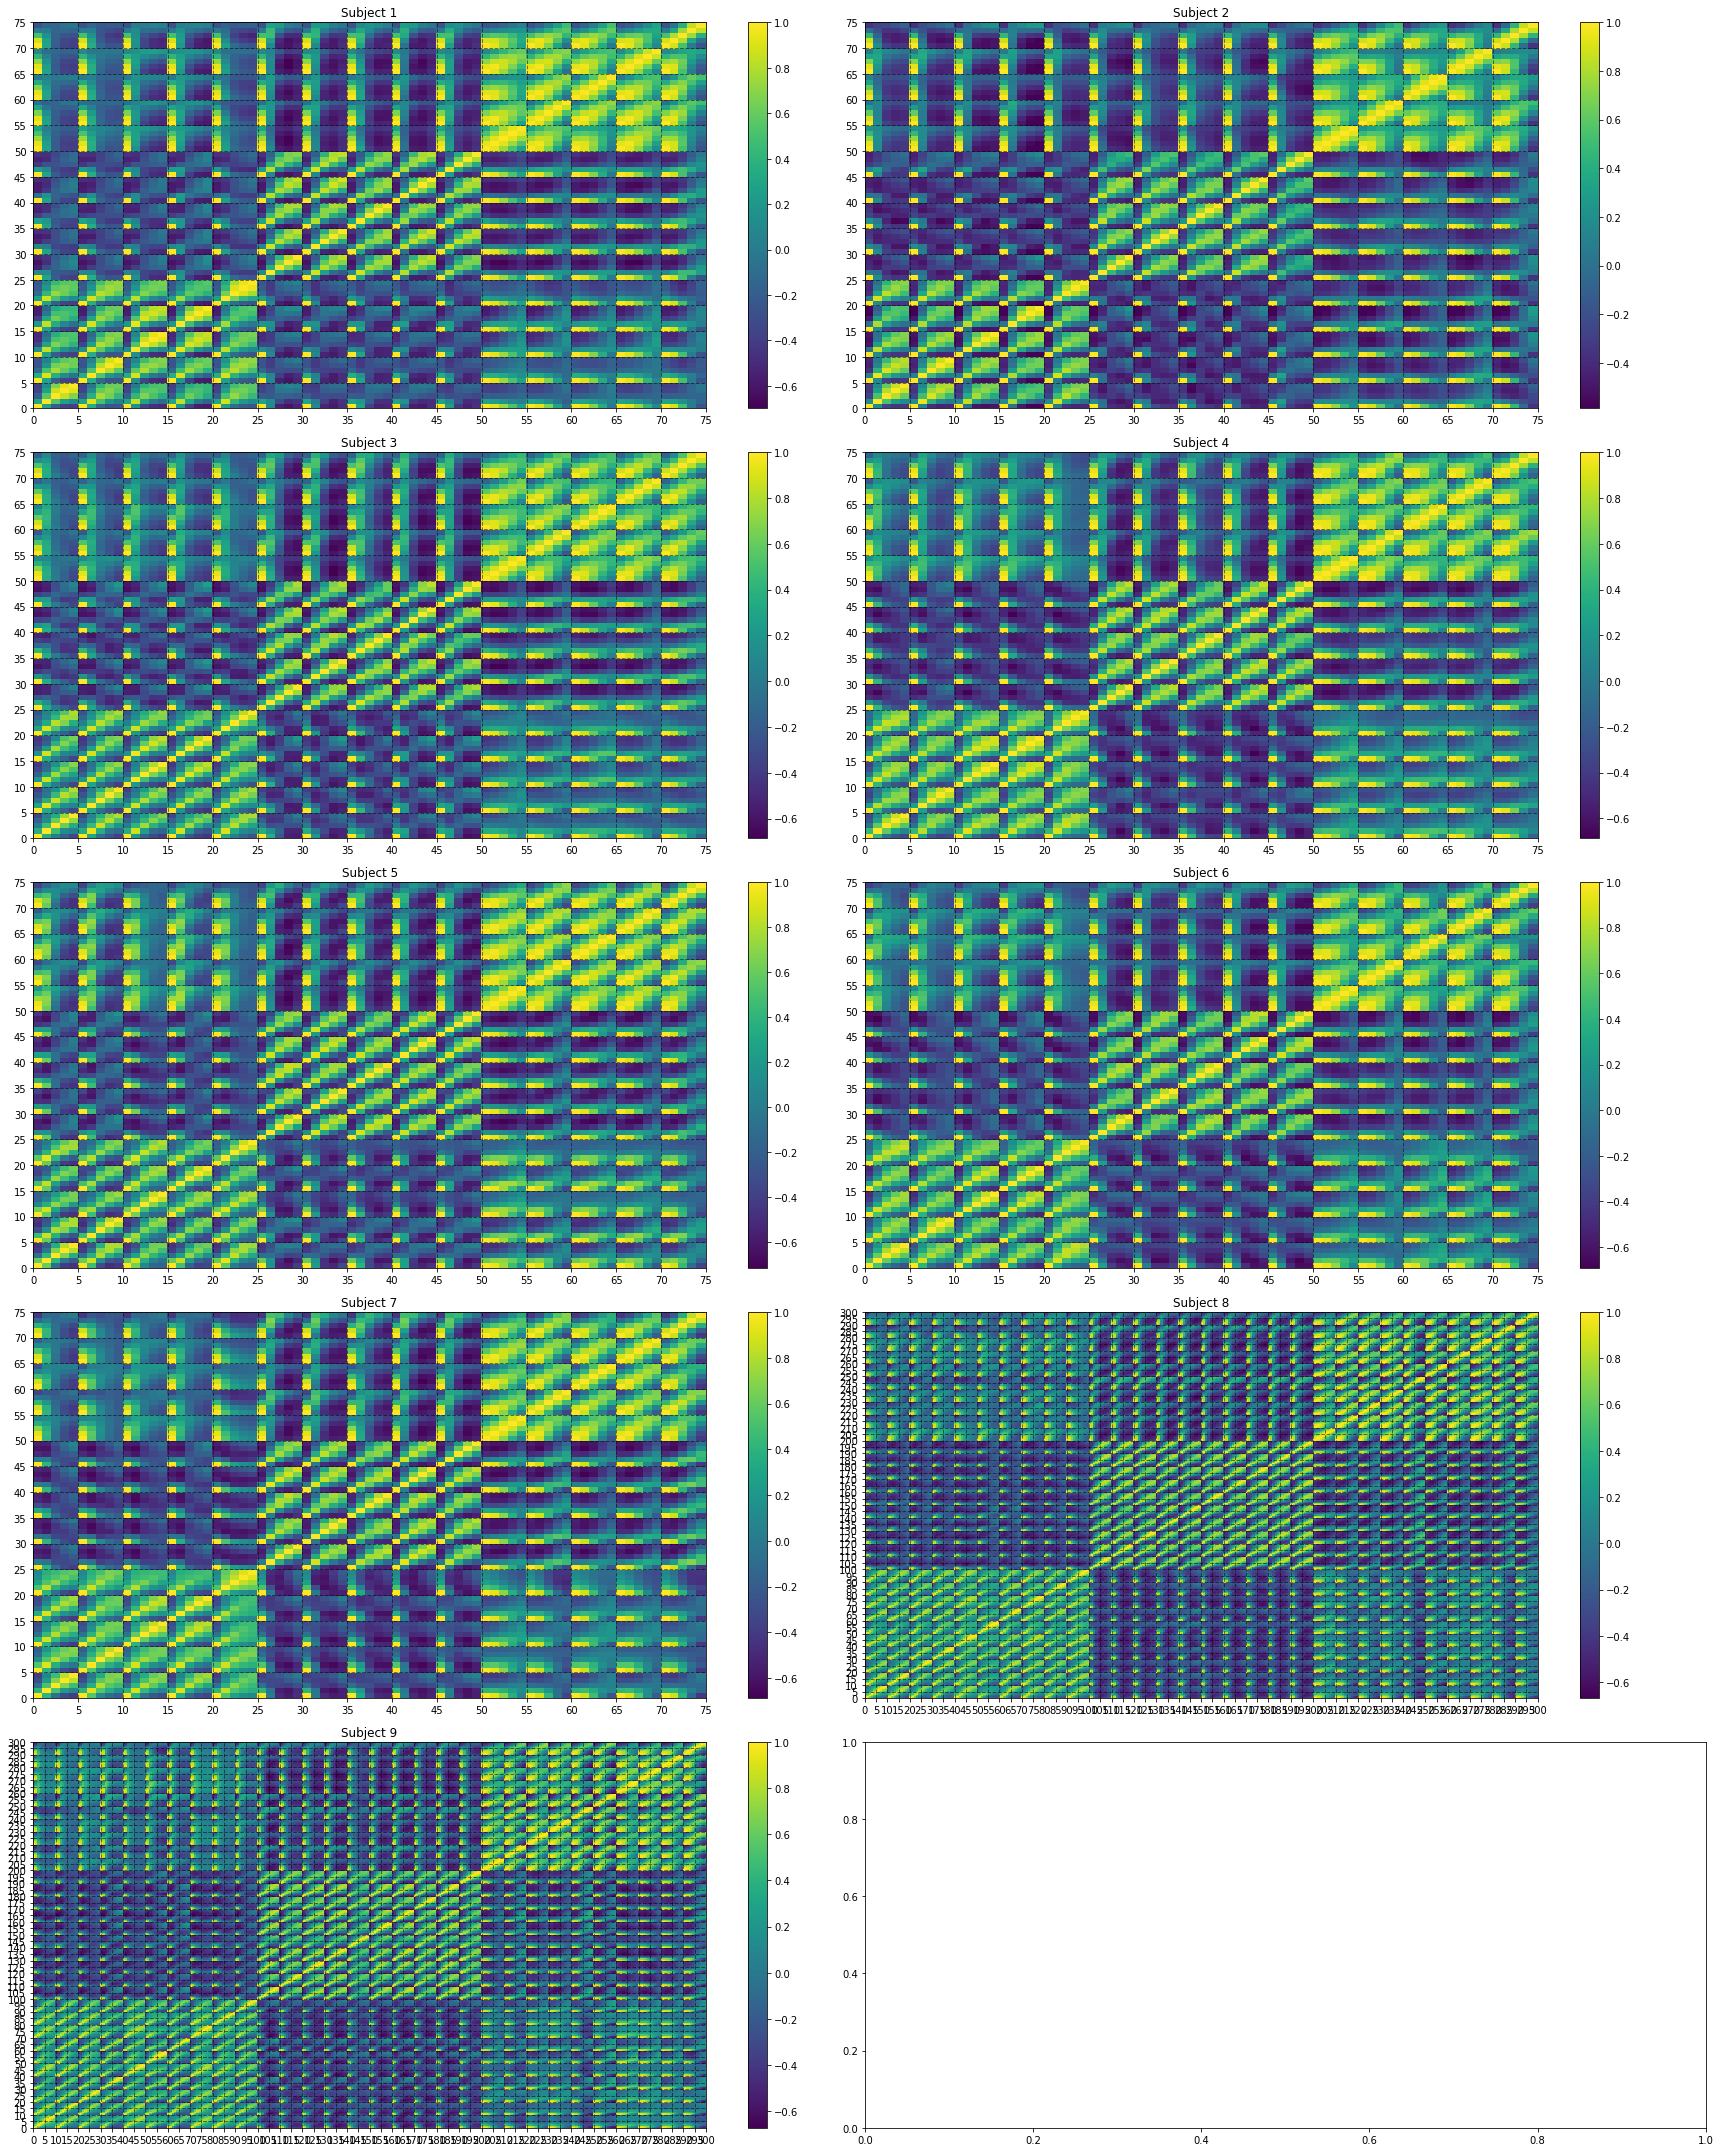

In [4]:
subjects = ['S105', 'S042','S125','S077','S094','S034','S124','S132','S088']
fig, axs = plt.subplots(5, 2, figsize=(24, 30))

# Loop through subjects and populate subplots
for i, s in enumerate(subjects):
    X = load_subject(s)[0]

    tr = transforms.Compose([transforms.Resize((256, 256)),
                             transforms.Grayscale(),transforms.ToTensor()])
    train_imgs = []
    for j, frame in enumerate(sorted(X)):
        print(frame)
        input_image = PIL.Image.open(frame).convert('RGB')
        transformed_image = tr(input_image)
        np_img = ((np.asarray(transformed_image)))[0]
        train_imgs.append(np_img)

    train_imgs = np.array(train_imgs)
    imgs_c = (train_imgs - np.mean(train_imgs,0)).reshape(train_imgs.shape[0],-1)

    # Calculate subplot position
    row = i // 2
    col = i % 2

    # Plot on the current subplot
    pc = axs[row, col].pcolor(np.corrcoef(imgs_c))
    axs[row, col].set_title(f'Subject {i + 1}')
    axs[row, col].grid(True, linewidth=1, color='black', linestyle='--', alpha=0.5)
    axs[row, col].set_xticks(np.arange(0, imgs_c.shape[0] + 1, 5))
    axs[row, col].set_yticks(np.arange(0, imgs_c.shape[0] + 1, 5))
    fig.colorbar(pc, ax=axs[row, col])

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot